In [3]:
import sys
sys.path.append('..')

import PIL
from PIL import Image

from torchvision import transforms as tfs
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 先对数据进行预处理

im_aug = tfs.Compose([
    tfs.Resize((100,100)),
    tfs.ToTensor()
])


start preparing the data...
finish preparing the data...
SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): ReflectionPad2d((1, 1, 1, 1))
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.2, inplace=False)
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_featu

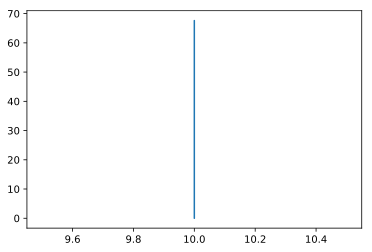

In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # 输入为 100 x 100
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            # 对每个 channel 按照概率设置为 0
            nn.Dropout2d(p=.2),
            # 输出为 4 * 100 * 100
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
            # 输出为 8 * 100 * 100

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
            # 输出为 8 * 100 * 100
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        # self.margin = torch.from_numpy(margin)
        self.margin = torch.tensor([margin])

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        temp = self.margin - euclidean_distance
        # loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2)
        #                             (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        loss_contrastive = ((1 - label) * torch.pow(euclidean_distance, 2)
                        + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))/2
        return loss_contrastive

class SiameseNetworkDataset():
    __epoch_size__ = 200
    def __init__(self,transform=None,should_invert=False):
        self.imageFolderDataset = []
        self.train_dataloader = []
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self):
        '''
        如果图像来自同一个类，标签将为0，否则为1
        '''
        img0_class = random.randint(0,40-1)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            temp = random.sample(list(range(0,10)), 2)
            img0_tuple = (self.imageFolderDataset[img0_class][temp[0]], img0_class)
            img1_tuple = (self.imageFolderDataset[img0_class][temp[1]], img0_class)
        else:
            img1_class = random.randint(0, 40 - 1)
            # 保证属于不同类别
            while img1_class == img0_class:
                img1_class = random.randint(0, 40 - 1)
            img0_tuple = (self.imageFolderDataset[img0_class][random.randint(0,9)], img0_class)
            img1_tuple = (self.imageFolderDataset[img1_class][random.randint(0,9)], img1_class)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        # 用以指定一种色彩模式, "L"8位像素，黑白
        # img0 = img0.convert("L")
        # img1 = img1.convert("L")

        # img0 = img0.resize((100,100),Image.BILINEAR)
        # img1 = img1.resize((100,100),Image.BILINEAR)  

        if self.should_invert:
            # 二值图像黑白反转
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        # if self.transform is not None:
        #     # 不知道是做什么用的
        #     img0 = self.transform(img0)
        #     img1 = self.transform(img1)
        
        # return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        return img0, img1, should_get_same_class

    def att_face_data(self):
        ''' AT&T 数据集: 共40类, 每类十张图像 '''
        local = 'D:/MINE_FILE/dataSet/att_faces/'
        self.imageFolderDataset = []
        for i in range(1, 40 + 1):
            temp = []
            sub_floder = local + 's' + str(i) + '/'
            for j in range(1, 10 + 1):
                temp.append(sub_floder + str(j) + '.pgm')
            self.imageFolderDataset.append(temp)
        # 为数据集添加数据
        for i in range(self.__epoch_size__):
            img0, img1, label = self.__getitem__()
            self.train_dataloader.append((img0, img1, label))
            # print("\r" + 'Cnt: ' + str(i)  + '/' + str(self.__epoch_size__) + '[' +">>" * i + ']',end=' ')

def show_plot(x, y):
    plt.plot(x, y)
    plt.show() 

if __name__ == '__main__':
    # net = SiameseNetwork().cuda()
    print('start preparing the data...')
    train_data = SiameseNetworkDataset()
    train_data.att_face_data()
    print('finish preparing the data...')

    net = SiameseNetwork()
    print(net)

    criterion = ContrastiveLoss()
    optimizer = optim.Adam(net.parameters(),lr = 0.0005 )
    
    counter = []
    loss_history = [] 
    iteration_number= 0
    train_number_epochs = 3

    for epoch in range(0,train_number_epochs):
        for i, data in enumerate(train_data.train_dataloader):
            img0, img1, label = data
            img0 = im_aug(img0)
            img1 = im_aug(img1)
            # img0 = torch.unsqueeze(img0, 0)
            # img1 = torch.unsqueeze(img1, 0)
            img0 = torch.unsqueeze(img0, dim=0).float()
            img1 = torch.unsqueeze(img1, dim=0).float()
            # img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
            output1,output2 = net(img0,img1)
            optimizer.zero_grad()
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            
            # counter.append(iteration_number)
            loss_history.append(float(loss_contrastive.data[0]))
            if i%20 == 0 :
                print("Epoch: {} step: {} Current loss {}".format(epoch,i,loss_contrastive.data[0]))
                # iteration_number = 10
            
    # show_plot(counter,loss_history)
    show_plot(counter, loss_history)

60


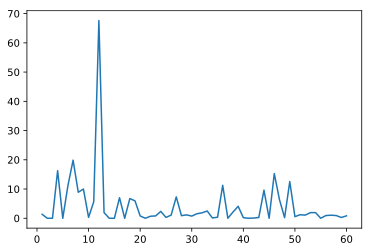

In [27]:
# show_plot(counter, loss_history)
# print(counter)
print(len(loss_history))
max(loss_history)

xx = []
yy = []
for i in range(60):
    xx.append(i+1)
    # yy.append(loss_history[i].float())
    yy.append(float(loss_history[i]))
# xx = counter.numpy().tolist()
# yy = loss_history.numpy().tolist()
plt.plot(xx, yy)
# plt.ylim(0, 1)
plt.show()
